# [Project - Bank Churn Prediction](https://olympus.greatlearning.in/courses/37431/assignments/110955?module_item_id=1013762)

**Objective:** Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

**Porblem Understanding:** Binary classification
Will use only one output neuron

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from yellowbrick.classifier import ClassificationReport, ROCAUC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

import keras
import tensorflow as tf
print(tf.__version__)

2.5.0


# Data Prep

## Reading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# Mounting drive to access dataset

data = '/content/drive/My Drive/GOOGLE COLAB/Project - ANN/bank.csv'
# data = 'ANN/bank.csv' #if using Jupyter
data = pd.read_csv(data)

print("\nColumns: ", data.columns)
# Output Columns from the Read CSV data.

print()
print("\nDimensions: ", data.shape)
print("Size: ", data.size)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).

Columns:  Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


Dimensions:  (10000, 14)
Size:  140000


**Observations:**
There are 140,000 elements, however, there appear to be non-value-add features for our model. More likely will be around 120000 - 110000 data points once some are dropped.

In [ ]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
data.info()
# Getting general view of data types we are worknig with.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Observations:**

Most features are numerical & there are no null values.

*Database Identifiers:*
 - RowNumber, CustomerId

*Object type Features:*
 - Surname, Geography, Gender

*Features that can be dropped:*
 - Surname, RowNumber, CustomerId

*Features adding value:*
 - CreditScore, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited, Geography, Gender

## Dropping Features
- Dropping non-value-add features for our model.
- Database Keys do not add value to predictions: 'RowNumber','CustomerId'
- The lastname will not provide value in analysis: 'Surname'

In [ ]:
cols = ['Exited', 'CreditScore', 'Balance', 'EstimatedSalary', 'Age', 'Tenure','NumOfProducts', 'HasCrCard', 'IsActiveMember',  'Geography', 'Gender']

# Setting aside columns in preferred order: Continous to the start & Categorical types go to the end. The Exception is our target variable which I will move to the front.

data = data[cols]
# Setting my dataframe to only close those of interest for the model.


# Exploratory Data Analysis


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00


**Observations & Insights**

The Median & Mean are about the same for 'CreditScore' , 'EstimatedSalary', 'Age', and 'Tenure' which may indicate no or low outliers as there would not be a long tail skewing the data for these features.
- Instead, the 'Balance' feature does have a 76k for the average 97k & a standard deviation of 62; indicate a large spread of the data.
- 'Tenure' most clients have been with the bank at least 5 years
- 'NumOfProducts' - Most clients only have one product
- 'HasCrCard' - Most clients have a credit card
- 'IsActiveMember' - As expected most are active members
- 'Exited' - very few have left the bank, less than 25%.

*Note:* Uniqueness will need to be checked for features: 'Geography' & 'Gender'

In [ ]:
print(data.nunique())
# Looking at the unique values for each feature.
print()
print(data['Geography'].unique())
#  Checking for Geo-categories.

Exited                2
CreditScore         460
Balance            6382
EstimatedSalary    9999
Age                  70
Tenure               11
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
Geography             3
Gender                2
dtype: int64

['France' 'Spain' 'Germany']


**Observations**
 - Geography spans across 3 countries, will need to be one-hot-encoded

In [ ]:
data['Exited'].value_counts()/data['Exited'].count()

0    0.7963
1    0.2037
Name: Exited, dtype: float64

## Sorting our data

In [ ]:
X = data.drop('Exited', axis=1)
y = data[['Exited']]
#printing the shape of the data 
print(y.shape)
print(X.shape)


(10000, 1)
(10000, 10)


In [ ]:
X.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
CreditScore,619,608,502,699,850,645,822,376,501,684,528,497,476,549,635,616,653,549,587,726,732,636,510,669,846,577,756,571,574,411,591,533,553,520,722,475,490,804,850,582,...,795,573,702,740,479,627,479,623,512,609,518,833,758,611,583,610,637,683,774,677,741,498,655,613,602,659,673,606,775,841,714,597,726,644,800,771,516,709,772,792
Balance,0,83807.9,159661,0,125511,113756,0,115047,142051,134604,102017,0,0,0,0,143129,132603,0,0,0,0,0,0,0,0,0,136816,0,141349,59697.2,0,85311.7,110113,0,0,134264,145260,76548.6,0,70349.5,...,104553,0,0,126524,117593,83199.1,125921,118469,153538,0,151027,144752,155740,0,122532,113957,103378,0,93017.5,90022.9,74371.5,152040,137145,0,90602.4,123841,183580,180308,0,0,35016.6,88381.2,0,155060,0,0,57369.6,0,75075.3,130143
EstimatedSalary,101349,112543,113932,93826.6,79084.1,149757,10062.8,119347,74940.5,71725.7,80181.1,76390,26261,190858,65951.6,64327.3,5097.67,14406.4,158685,54724,170886,138555,118914,8487.75,187616,124508,170042,38433.3,100187,53483.2,140469,156732,81898.8,34410.6,142033,27823,114067,98453.4,40812.9,178074,...,120854,107124,59207.4,136869,113308,159335,20393.4,158590,23101.1,112585,119377,166473,171552,157474,13549.2,196527,84419.8,24991.9,191609,2988.28,99595.7,53445.2,115146,151325,51695.4,96833,34047.5,1914.41,49337.8,179437,53667.1,69384.7,195192,29179.5,167774,96270.6,101700,42085.6,92888.5,38190.8
Age,42,41,42,39,43,44,50,29,44,27,31,24,34,25,35,45,58,24,45,24,41,32,38,46,38,25,36,44,43,29,39,36,41,42,29,45,31,33,36,41,...,33,44,44,33,34,33,35,48,40,41,42,34,26,27,33,50,33,32,40,58,35,42,46,40,35,36,47,30,30,28,33,53,36,28,29,39,35,36,42,28
Tenure,2,1,8,1,2,8,7,4,4,2,6,3,10,5,7,3,1,9,6,6,8,8,4,3,5,3,2,9,3,0,3,7,9,6,9,0,3,7,7,6,...,9,9,9,2,5,4,4,5,8,6,7,3,4,7,7,1,7,9,9,1,6,3,7,4,7,6,1,8,4,4,3,4,2,7,2,5,10,7,3,4
NumOfProducts,1,1,3,2,1,2,2,4,2,1,2,2,2,2,2,2,1,2,1,2,2,2,1,2,1,2,1,2,1,2,3,1,2,2,2,1,1,1,1,2,...,1,2,1,1,2,1,1,1,2,1,2,1,1,2,1,2,1,2,2,1,1,1,1,1,2,2,2,2,2,2,1,1,1,1,2,2,1,1,2,1
HasCrCard,1,0,1,0,1,1,1,1,0,1,0,1,1,0,1,0,1,1,0,1,1,1,1,0,1,0,1,0,1,1,1,0,0,1,1,1,0,0,1,0,...,1,1,0,1,0,0,1,1,0,0,1,0,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1,1,0,1,1
IsActiveMember,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,1,0,1,0,1,1,0,0,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,1,1,...,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0
Geography,France,Spain,France,France,Spain,Spain,France,Germany,France,France,France,Spain,France,France,Spain,Germany,Germany,Spain,Spain,France,France,Spain,Spain,France,France,France,Germany,France,Germany,France,Spain,France,Germany,Spain,Spain,France,Spain,Spain,France,Germany,...,Germany,Spain,Spain,Germany,France,Germany,Spain,France,Germany,France,France,France,France,France,France,Germany,France,France,France,France,Spain,Germany,Germany,France,Germany,France,Germany,Spain,France,Spain,Germany,France,Spain,France,France,France,France,France,Germany,France
Gender,Female,Female,Female,Female,Female,Male,Male,Female,Male,Male,Male,Male,Female,Female,Female,Male,Male,Female,Male,Female,Male,Female,Female,Male,Female,Male,Male,Male,Female,Male,Female,Male,Male,Female,Female,Female,Male,Male,Male,Male,...,Female,Male,Male,Male,Male,Female,Male,Male,Female,Male,Male,Female,Male,Male,Male,Male,Female,Female,Male,Female,Male,Male,Female,Male,Male,Male,Male,Male,Male,Male,Male,Female,Male,Male,Female,Male,Male,Female,Male,Female


In [ ]:
y.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Exited,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0


**Observations**

None of the features were very significantly correlated.
Top Correlation Features with the Exited feature are the following:
 - *Positive*: Age, Balance
  - As Age increases the more likely they are to leave the bank
  - As Balance increases the more likely they are to leave the bank 
 - *Negative*: isActiveMember & NumOfProucts
  - Active Members are less likely to leave the bank
  - The more products a client has the less likely they are to leave.
  - The higher the credit score the more likely they are to stay

Other observations:
- The more products a customer has the more likely they are to have a higher balance.
- The more active & the more number of products a customer has, the less likely they are to exit. Their credit score has some impact but is marginal.

- The higher the balance & the older (higher in age) the more likely the client is to exit.

**Observations**

Our target feature is imbalanced. The atypical events are what we are tryin to predict with our model.

- The data data is split to 7963 stayed, 2037 left the bank.
 - 79.63% vs 20.37% imbalance.

**Assumption made**: 0 is the ones that stayed with the bank, 1 is the ones that left


## EDA Visualizations

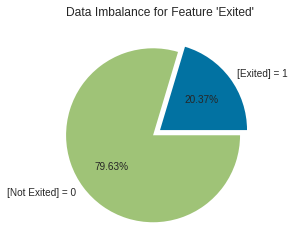

In [ ]:
# Labels for visuals: Pie Chart & Confusion Matrix
labels = '[Exited] = 1', '[Not Exited] = 0'

binaryFeatures = [data.Exited[data['Exited']==1].count(), data.Exited[data['Exited']==0].count()]
fig1, ax1 = plt.subplots(figsize=(4, 4))
ax1.pie(binaryFeatures, explode=(0, 0.1), labels=labels, autopct='%1.2f%%')
plt.title("Data Imbalance for Feature \'Exited\'")
plt.show()

**Observation**
 - The pie chart shows the large disparity in the binary classification of the Exited feature. This will affect the performance of our future model if measures are not taken. 

In [ ]:
# sns.pairplot(data = data, kind= "scatter", hue = 'Exited');

**Observations**

- No clear linear correlation exists, however there is a high concentration of exited in the Age column, between the age of 40 & 60. Also, another high concentration of exited customers occurs for those with More than 2 Products.

- We can see 'CreditScore' & 'Age' are normally distributed.

- 'Balance' has a Bimodal Distribution.

- 'EstimatedSalary' is Gaussian distribution with a plateau, slightly favoring right tail.

- 'Tenure' is more categorical but also seems to be polynomially distributed with no significant outliers.

- On reviewing the 'NumOfProducts' feature with the HasCrCard, it would seem most of the clients are credit card holders as most have two or fewer financial products.

- Most members are active members, however, the distinction is about 20%.


*NOTE:* Take a closer look at Age, NumOfProducts, HasCrCard

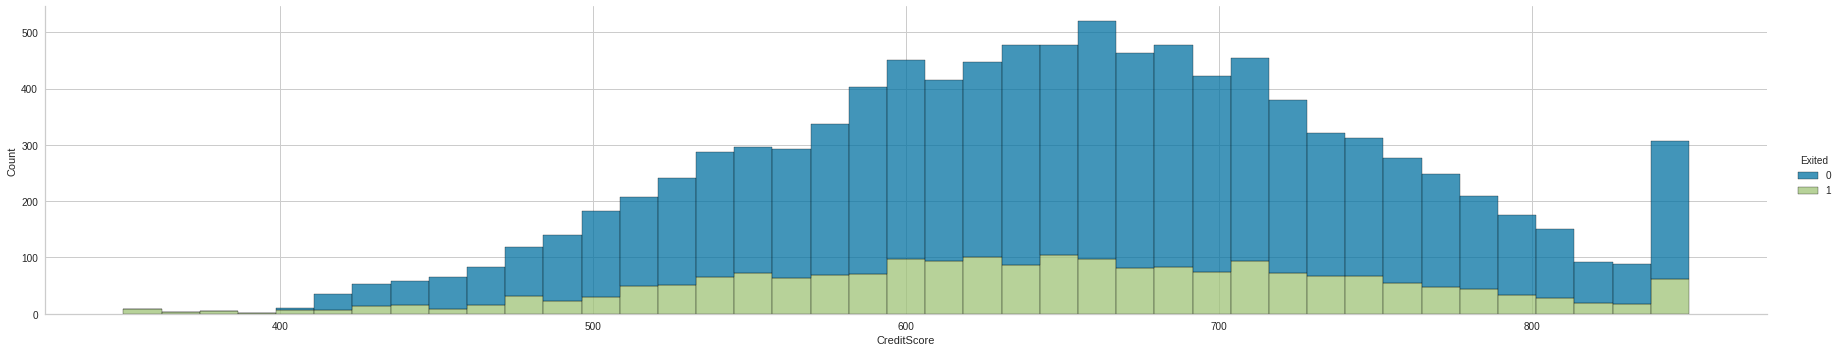

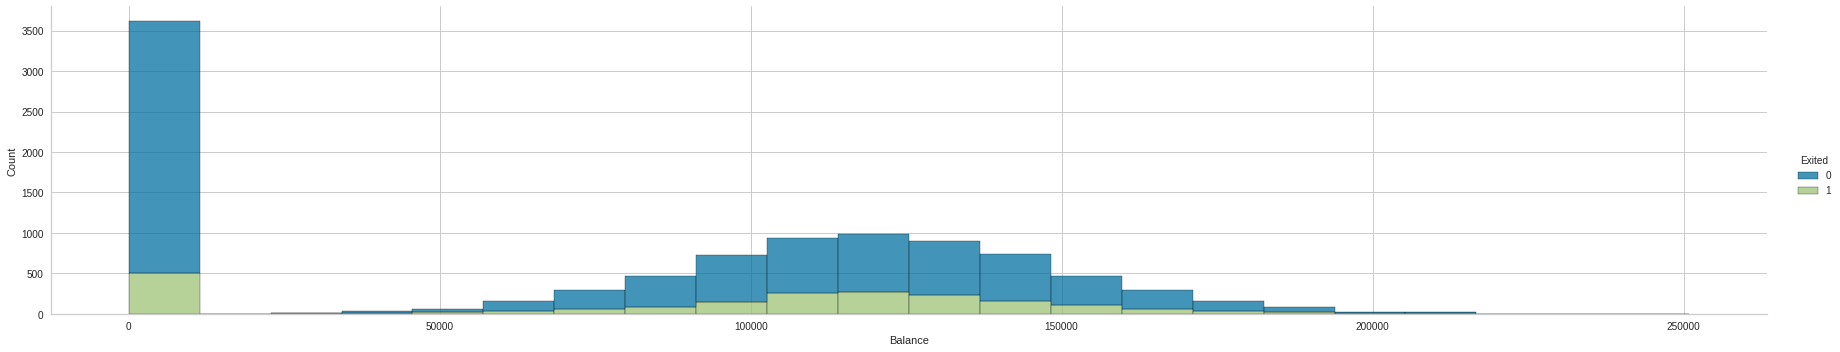

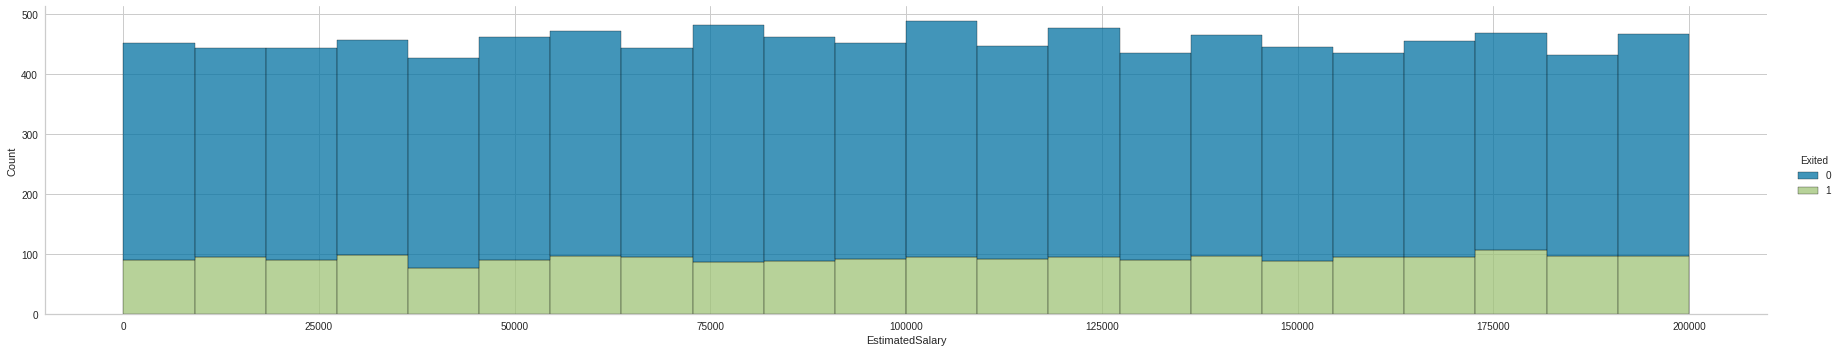

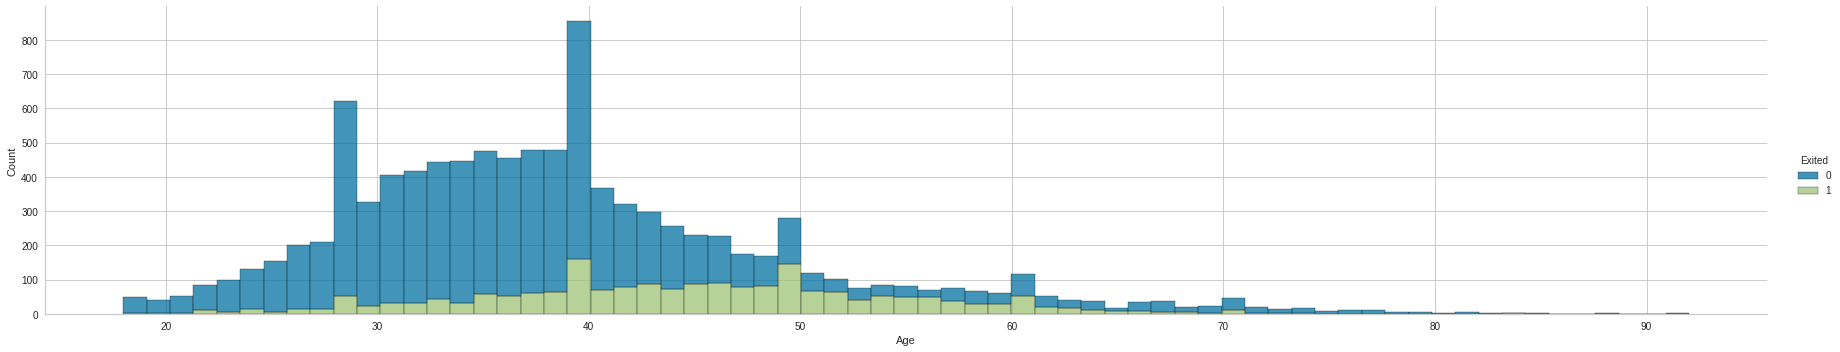

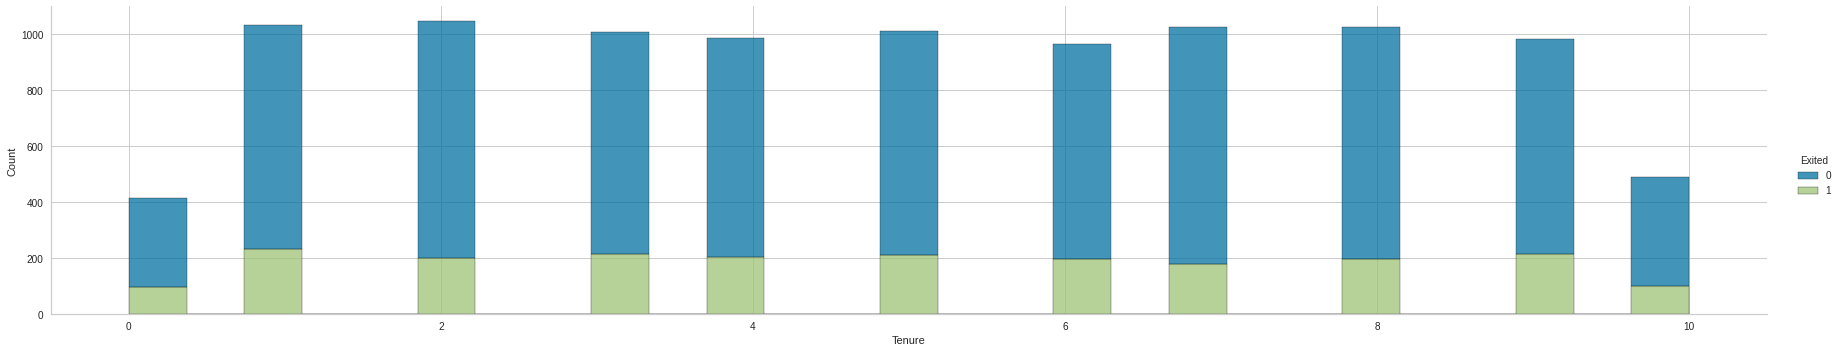

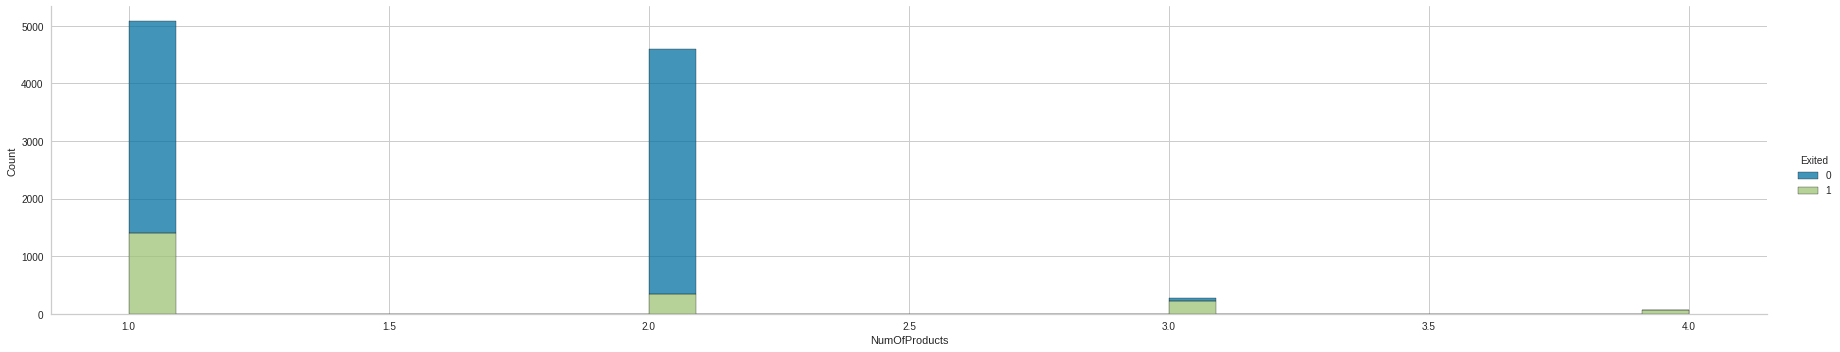

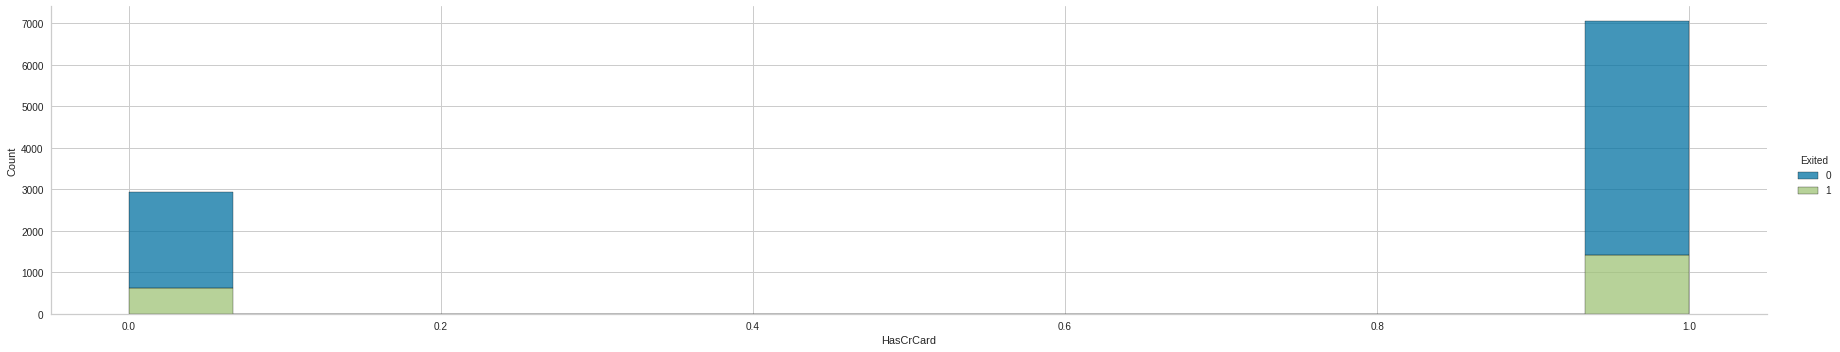

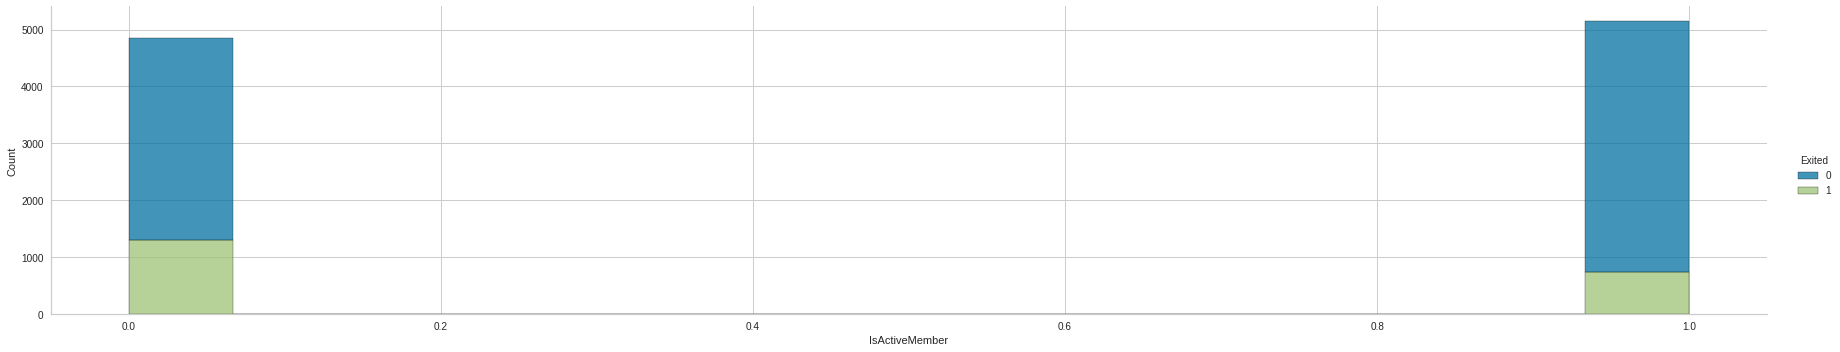

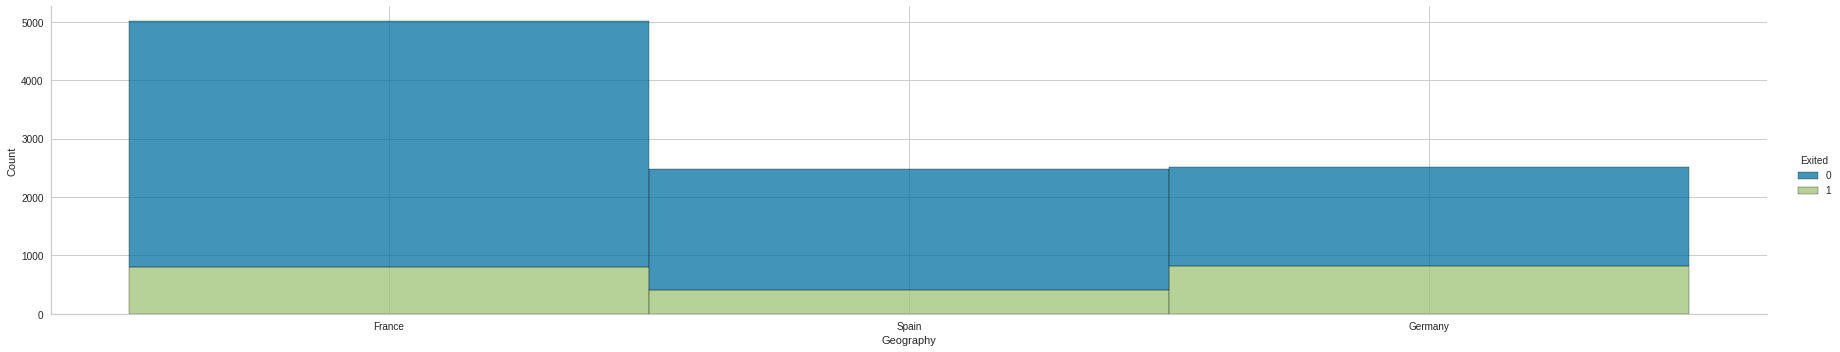

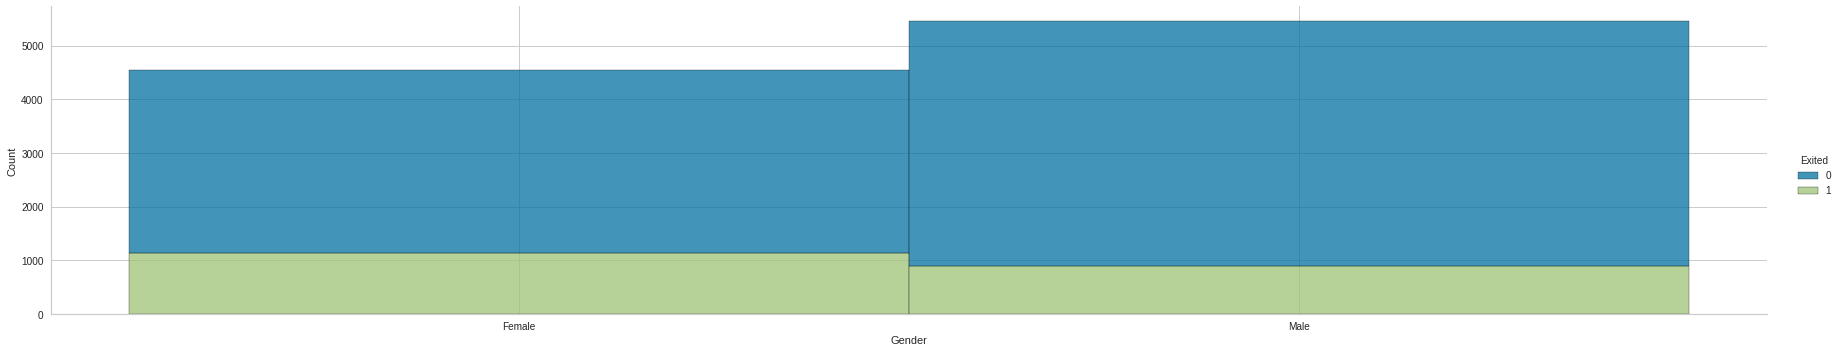

In [ ]:
for i in range(1,11):
  sns.displot(data, x=data[cols[i]], hue=data['Exited'], multiple="stack", aspect=5, height=5)
  plt.show()

**Observations**
 - Clients close to the 400 credit score seem to leave the bank more than those that stay. The same can be said with those with the highest credit rating.
 - There are many clients with no bank balance which may be aligned with those who have a credit card.
 - The exit range amongst the Estimated Salary range has low variability across the different amounts.
 - There appears to be a large tendency in groups around. While the data is normally distributed, there is a high density at around ages 28 & 38 & 49 & 61.
 - Tenure again seems to have a plateau & the exit rate seems to be consistent through the years.
 - Customers with fewer products stay with the bank. The ones with 3 or 4 seem to leave more often than they stay. 
 - Clients have almost twice as many credit cards as those that do not.
 - As Expected, clients that are not active are the ones most have more often left the bank than those that are active.
 - The customer base is heavily located in France with Spain & Germany having about the same. Overall Germans were the most likely to exit followed by the French.
 - More customers were male, however, the Females had the highest rate of attrition.

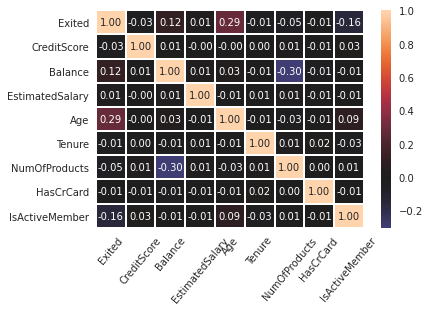

Exited             1.000000
Age                0.285323
Balance            0.118533
EstimatedSalary    0.012097
HasCrCard         -0.007138
Tenure            -0.014001
CreditScore       -0.027094
NumOfProducts     -0.047820
IsActiveMember    -0.156128
Name: Exited, dtype: float64

In [ ]:
sns.heatmap(data.corr(), annot=True, linewidths=1, center=0, cbar=True, fmt='0.2f', )
size=10

# Aesthetics for heatmap
# plt.yticks(rotation = 20)
plt.xticks(rotation = 50)  
sns.color_palette("rocket", as_cmap=True)
sns.set(rc={'figure.figsize':(size,size)})
plt.show()

# Display ordered correlation for our target feature
data.corr()['Exited'].sort_values(ascending=False)


# Data Pre-processing

In [ ]:
# ONE-HOT-ENCONDING w\ 1ST DROP
X = pd.get_dummies(X, columns = ['Geography', 'Gender']  ,  drop_first = True)

In [ ]:
# Rescaling the Data

# Instantiate the MinMaxScaler
scaler = MinMaxScaler()
# Fit & Transform
scaler.fit(X)
X= scaler.transform(X)
# Confirmation data is transformed
print(X)

[[0.538      0.         0.50673489 ... 0.         0.         0.        ]
 [0.516      0.33403148 0.56270874 ... 0.         1.         0.        ]
 [0.304      0.63635718 0.56965435 ... 0.         0.         0.        ]
 ...
 [0.718      0.         0.21039009 ... 0.         0.         0.        ]
 [0.844      0.29922631 0.46442905 ... 1.         0.         1.        ]
 [0.884      0.51870777 0.19091423 ... 0.         0.         0.        ]]


### Train-Test Data Processing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

# #split the data into TRAIN , TEST , VALIDATION
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)
# #80/20 train/test split
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state = 0)

# Building Models

In [ ]:
categories = labels

#### Functions

In [ ]:
# Borrowed from previous notebooks. Some Modifications have been made
def make_confusion_matrix(cf, group_names=None, categories='auto', count=True, percent=True, cbar=True, xyticks=True,
xyplotlabels=True, sum_stats=True, figsize=(5,5), cmap=None, title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''
    #declare labels to add to Confusion Matrix
    labels = ['True Negative','False Positive','False Negative','True Positive']

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]
    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""
    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')
    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False
    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    if title:
        plt.title(title)

def eval_ROC_AUC(NeuralModel, x_test, y_test, spitBack=False):
  # Predictions
  yPred = NeuralModel.predict(x_test)

  # Score model's ROC-AUC predictions
  score = roc_auc_score(y_test, yPred)
  print('ROC-AUC: %.3f' % score)
  if(spitBack):
    return score

def show_ROC_AUC(Model, xtest, ytest, xtrain, ytrain):
  roc = ROCAUC(Model)
  roc.fit(xtrain, ytrain)
  roc.score(xtest, ytest)
  

### Logistic Regression Model

Training accuracy 0.81225

Testing accuracy 0.813


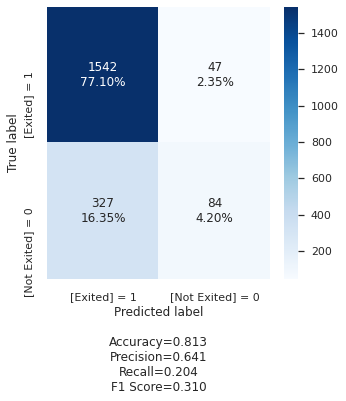

In [ ]:
from sklearn.linear_model import LogisticRegression   # importing logistic regression from scikit learn
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score

modelLR = LogisticRegression(random_state=7).fit(X_train, y_train) #training of model
y_pred = modelLR.predict(X_test)     #model is predicting y values based on test dataset given to the model

print("Training accuracy",modelLR.score(X_train,y_train))  # this will give training accuracy as training data has been used
print()
print("Testing accuracy",modelLR.score(X_test, y_test))   # this will give testing accuracy as testing data has been used

make_confusion_matrix(confusion_matrix(y_test, y_pred), group_names=labels, categories=categories, cmap='Blues')

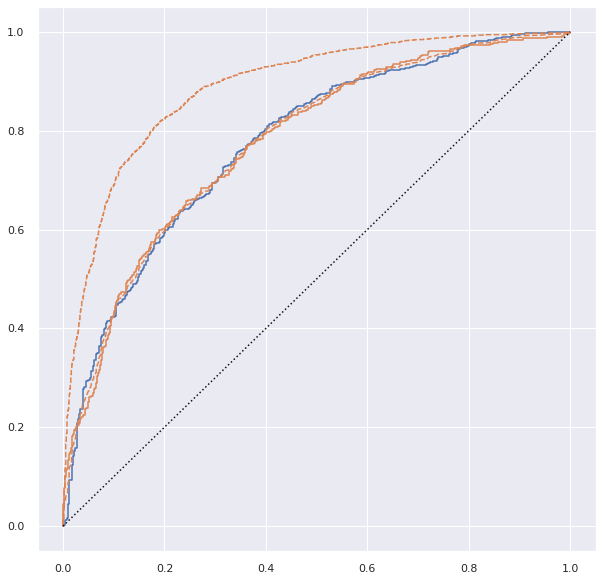

In [ ]:
show_ROC_AUC(modelLR, X_test, y_test, X_train, y_train)

**For 1 the Optimal Threshold occurs around .25**
**For 0 the Optimal Threshold occurs around .35**

### Random Forest Model

Mean Accuracy 0.86


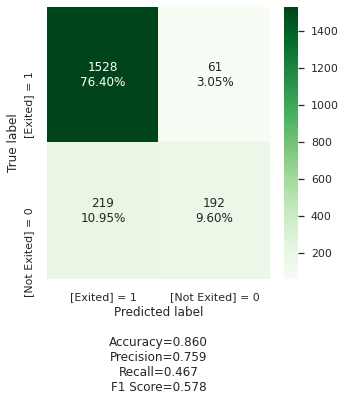

In [ ]:
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier(n_estimators=100)
modelRF.fit(X_train,y_train.values.ravel())    # np.ravel() Return a contiguous flattened array
y_pred = modelRF.predict(X_test)
print('Mean Accuracy' , modelRF.score(X_test,y_test))
make_confusion_matrix(confusion_matrix(y_test, y_pred), group_names=labels, categories=categories, cmap='Greens')


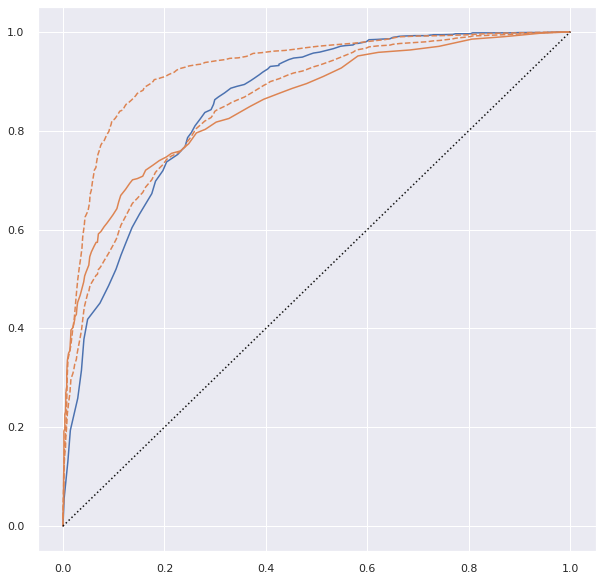

In [ ]:
show_ROC_AUC(modelRF, X_test, y_test, X_train, y_train)

**For 1 the Optimal Threshold occurs around .15**
**For 0 the Optimal Threshold occurs around .25**

### Deep Neural Network & Improvement

#### Model 1: 1 hidden Layer, 4 neurons

63/63 [==============================] - 0s 988us/step - loss: 0.3686 - accuracy: 0.8400
accuracy: 0.8399999737739563
loss:  0.36855214834213257


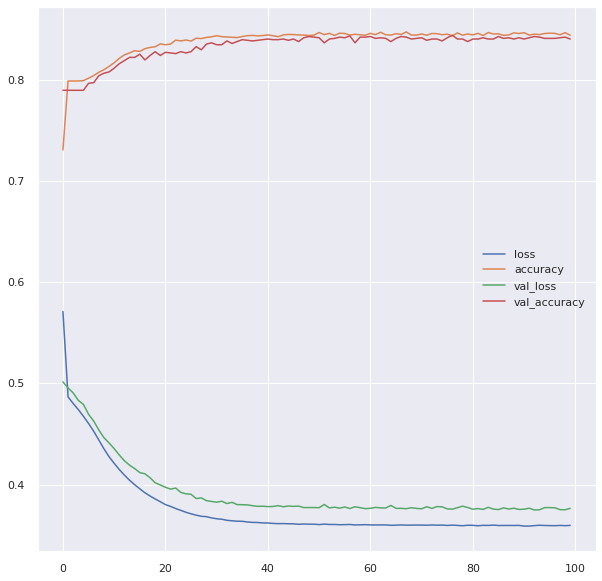

In [ ]:
# Initialize empty sequenial model
model =  tf.keras.models.Sequential()

# Adding Hidden Layer
model.add( Dense(4,  activation='relu' ) )
# Adding Output Layer for BINARY CLASSIFICATION
model.add( Dense(1,  activation='sigmoid') )

# Compile model for BINARY CLASSIFICATION
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

# Fit model to X-Y Train
model.fit(X_train,y_train , batch_size=15 , epochs=100 , validation_split=0.2 , verbose=0)

losses1  =  pd.DataFrame(model.history.history)
losses1.plot()

score1 = model.evaluate(X_test, y_test)
print('accuracy:', score1[1])
print('loss: ', score1[0])

**Observation**: 

The model did well with an accuracy of about 83.9999%

The model should be able to improve with some tuning

**The best evaluation metric will be Accuracy as there is no direct-penalty for losing a client. There is no cost for having a client leave the bank.**


#### Model 2: 4 hidden Layer, 4,6,8,10 neurons with 'he_normal'

63/63 [==============================] - 0s 953us/step - loss: 0.3451 - accuracy: 0.8560
accuracy: 0.8560000061988831
loss:  0.34506115317344666


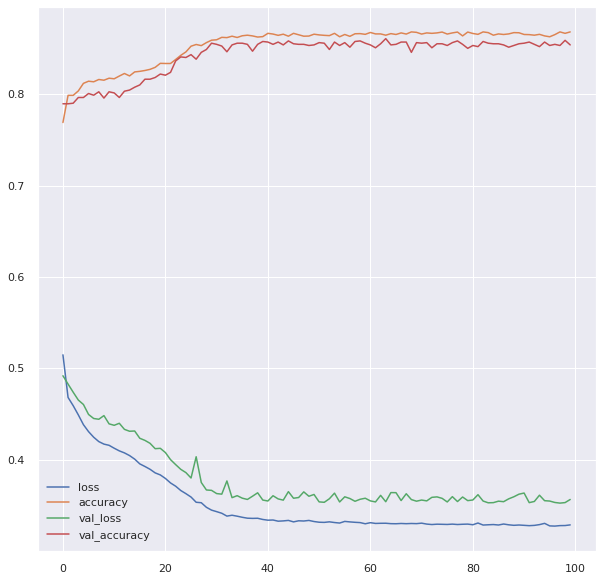

In [ ]:
# Initialize empty sequenial model
modell = tf.keras.models.Sequential()

# Adding 4 layers, 2 with kernel_initializer, 1 output layer
modell.add(Dense(4, activation='relu',  kernel_initializer='he_normal'))
modell.add(Dense(6, activation='relu'))
modell.add(Dense(8, activation='relu',  kernel_initializer='he_normal'))
modell.add(Dense(10, activation='relu'))
modell.add(Dense(1, activation='sigmoid'))
modell.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])


modell.fit(X_train,y_train,batch_size=15,epochs=100,validation_split=0.2,verbose=0)

losses  =  pd.DataFrame(modell.history.history)
losses.plot()

score2 = modell.evaluate(X_test, y_test)
print('accuracy:', score2[1])
print('loss: ', score2[0])

**The Model performed a little better @ around 85.60%**

#### Model 3: 4 hidden Layer, 4,6,8,10 neurons with 'he_normal'

63/63 [==============================] - 0s 979us/step - loss: 0.3445 - accuracy: 0.8620
accuracy: 0.8619999885559082
loss:  0.34450963139533997


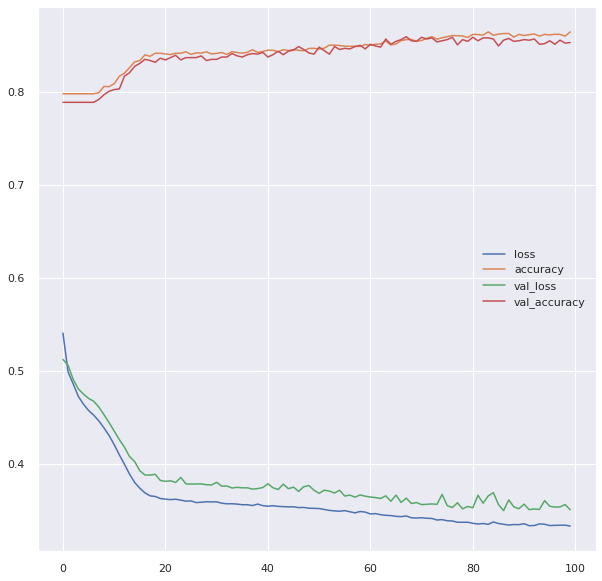

In [ ]:
# Initialize empty sequenial model
modelll = tf.keras.models.Sequential()

# Adding 4 layers, 2 with kernel_initializer, 1 output layer
modelll.add(Dense(4, activation='relu',  kernel_initializer='he_normal'))
modelll.add(Dense(6, activation='relu'))
modelll.add(Dense(8, activation='relu',  kernel_initializer='he_normal'))
modelll.add(Dense(10, activation='relu'))
modelll.add(Dense(1, activation='sigmoid'))
modelll.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

# setting the early stop
early_stop = EarlyStopping(monitor = 'accuracy', mode = 'max', verbose = 0, patience = 25)

# fitting the model to our train data
modelll.fit(X_train,y_train,batch_size=15,epochs=100,validation_split=0.2,verbose=0)


losses  =  pd.DataFrame(modelll.history.history)
losses.plot()

score3 = modelll.evaluate(X_test, y_test)
print('accuracy:', score3[1])
print('loss: ', score3[0])

**The model did even better @ about 86.19%**

In [ ]:
## Classical ML models are not counted in evaluation due to low accuracy.#
# eval_ROC_AUC(modelLR, X_test, y_test)
# eval_ROC_AUC(modelRF, X_test, y_test)

print('\nModel 1')
print('Accuracy: ',score1[1])
eval_ROC_AUC(model, X_test, y_test)

print('\nModel 2')
print('Accuracy: ',score2[1])
eval_ROC_AUC(modell, X_test, y_test)

print('\nModel 3')
print('Accuracy: ',score3[1])
eval_ROC_AUC(modelll, X_test, y_test)



Model 1
Accuracy:  0.8399999737739563
ROC-AUC: 0.842

Model 2
Accuracy:  0.8560000061988831
ROC-AUC: 0.856

Model 3
Accuracy:  0.8619999885559082
ROC-AUC: 0.857


Of the three models create, the best one was the one is Model 3.
There wasn't much of a distinction from the other two.
- 4 hidden layers using relu & one output layer using sigmoid
  - 2 using kernel_initializer='he_normal'
  - 2 without kernel_initializer
  - 1 output layer

Setting the early stop stop helped ap the epochs at 63 by monitoring for maximum accuracy.
The model was compiled for 'binary_crossentropy' loss, optimized using 'adam' for 'accuracy.'

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

100/100 [==============================] - 0s 1ms/step - loss: 0.5254 - accuracy: 0.7392
accuracy: 0.7391713857650757
loss:  0.5253555774688721


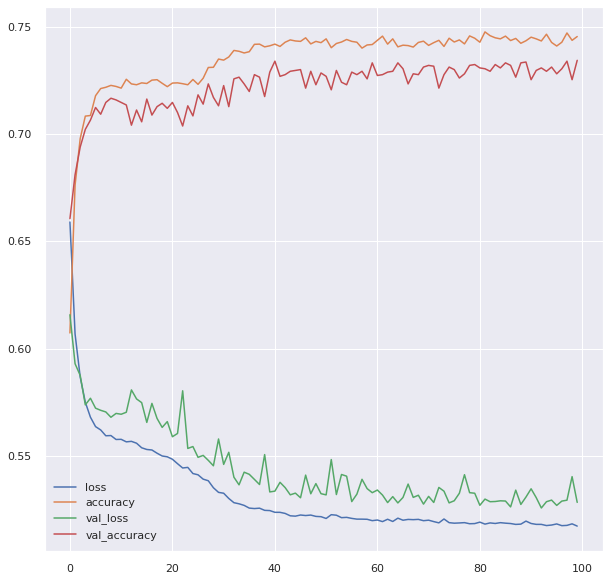

In [ ]:
# Initialize empty sequenial model
modelll = tf.keras.models.Sequential()

# Adding 4 layers, 2 with kernel_initializer, 1 output layer
modelll.add(Dense(4, activation='relu',  kernel_initializer='he_normal'))
modelll.add(Dense(6, activation='relu'))
modelll.add(Dense(8, activation='relu',  kernel_initializer='he_normal'))
modelll.add(Dense(10, activation='relu'))
modelll.add(Dense(1, activation='sigmoid'))
modelll.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

# setting the early stop
early_stop = EarlyStopping(monitor = 'accuracy', mode = 'max', verbose = 0, patience = 25)

# fitting the model to our train data
modelll.fit(X_train,y_train,batch_size=15,epochs=100,validation_split=0.2,verbose=0)


losses  =  pd.DataFrame(modelll.history.history)
losses.plot()

score3 = modelll.evaluate(X_test, y_test)
print('accuracy:', score3[1])
print('loss: ', score3[0])

**It appears the using Synthetic Data (SMOTE) is not a good strategy for dealing with the data imbalance & the final model did worse than Model 3.**

# Conclusion and Key Takeaways
While the classical models of Logistic Regression & Random Forest are a good start. Using Neural Networks is a more effective tool for classification problems. With the multitude of hyper-parameters available, the backpropagation & optimizer, Neural Networks are much more powerful than any classical model alone.


Although NN is great, they are still susceptible to data imbalances. There are various techniques that can be used to deal with these, however, SMOTE was not a particularly effective technique.


On reviewing the accuracy of the three models, Model 3 was the most effective with an Accuracy of 0.862 & a ROC-AUC: 0.857 it was the one that performed the best. Based on current data and model training, we can be correct about 86% of the time when predicting if a client will leave the bank.


Feeding the model-new clients through the model will give the bank an opportunity to interact with the customer and potentially offer a value-added product or engage with the client more often in the expectation that they will remain clients of the bank.
